In [ ]:
%pylab inline
!pip install natsort

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from natsort import natsorted
from PIL import Image

torch.manual_seed(1)

Dataset: https://www.kaggle.com/basu369victor/style-transfer-deep-learning-algorithm/data

Paper: https://arxiv.org/abs/1703.06868

Architecture: https://github.com/naoto0804/pytorch-AdaIN/blob/master/net.py

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data
def unzip(path, name_folder):
    with ZipFile(path, 'r') as zipObj:
        # Extract all the contents of zip file in different directory
        zipObj.extractall(name_folder)
        print('File is unzipped in temp folder')
unzip('../input/painter-by-numbers/train_1.zip', 'style')

In [ ]:

class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
BS = 16
LR = 1e-4
LAMBDA = 1
epochs = 1

In [ ]:
std_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

style_ds = torchvision.datasets.ImageFolder(root = 'style', transform = std_transform)
style_loader = torch.utils.data.DataLoader(style_ds, batch_size=BS, shuffle = True, drop_last = True)


content_ds = CustomDataSet('../input/coco-2017-dataset/coco2017/train2017', transform=std_transform)
content_loader = torch.utils.data.DataLoader(content_ds, batch_size=BS, shuffle = True, drop_last = True)

In [ ]:
def concat_img(imgs):
    figsize(16,16)
    figure()
    #imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy() 
    axs = imshow(np.concatenate(imgs.tolist(), axis=1))
    plt.axis('off')
    plt.show()

style, label = next(iter(style_loader))
print("Style examples")
concat_img(style[:12])
content = next(iter(content_loader))
print("Content images")
concat_img(content[:12])

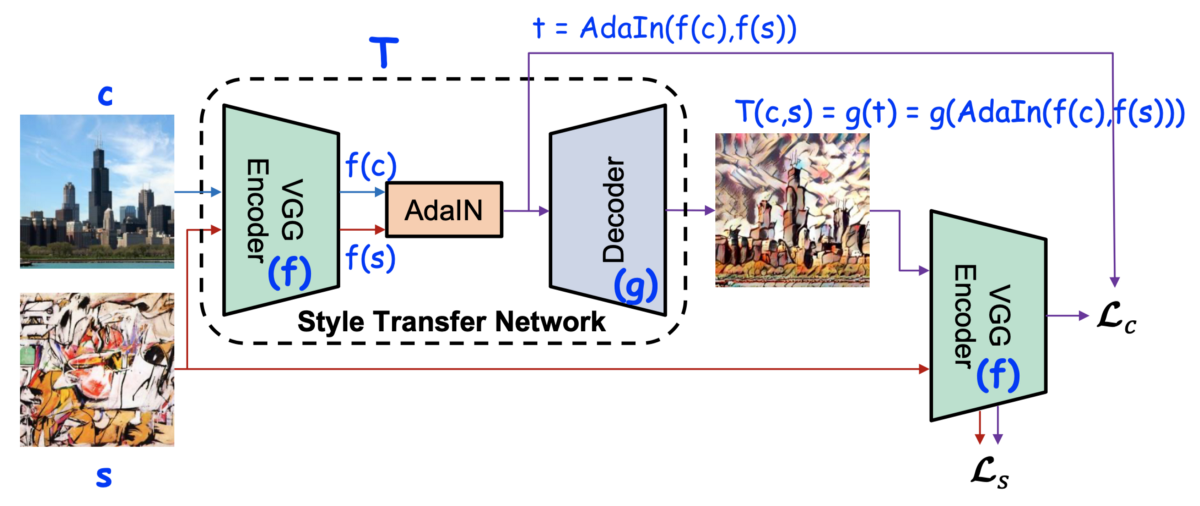

In [ ]:
class VGG_Encoder(torch.nn.Module):
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        pretrained = torchvision.models.vgg19(pretrained=True)
        
        f = torch.nn.Sequential(*list(pretrained.features.children())[:21]).eval()
        
        # Splitting the network so we can get output of different layers
        # TODO: ADD REFLECTION PADDING LAYERS
        self.relu1_1 = torch.nn.Sequential(*f[:2],)
        self.relu2_1 = torch.nn.Sequential(*f[2:5], *f[5:7])
        self.relu3_1 = torch.nn.Sequential(*f[7:10],*f[10:12])
        self.relu4_1 = torch.nn.Sequential(*f[12:14],
                                          *f[14:16],
                                          *f[16:19],
                                           *f[19:21])

    def forward(self, x):
        out_1 = self.relu1_1(x)
        out_2 = self.relu2_1(out_1)
        out_3 = self.relu3_1(out_2)
        result = self.relu4_1(out_3)
        return out_1, out_2, out_3, result

def mean_and_std(x):
    x = x.view(x.shape[0], x.shape[1], -1)
    mean = x.mean(dim=2) + 0.00005
    std = x.var(dim=2).sqrt()
    return mean.view(mean.shape[0], mean.shape[1], 1, 1), std.view(std.shape[0], std.shape[1], 1, 1)

class AdaIN(torch.nn.Module):
    def __init__(self):
        super(AdaIN, self).__init__()
        self.IN = torch.nn.InstanceNorm2d(512)
    
    def forward(self, x, y):
        size = x.size()
        
        x = self.IN(x)
        
        #mean_x, std_x = mean_and_std(x)
        mean_y, std_y = mean_and_std(y)
        #x = (x - mean_x.expand(size)) / std_x.expand(size)
        x = x * std_y.expand(size) + mean_y.expand(size)
        return x
""""
print(style.shape)
mean, std = mean_and_std(style)
print(mean.shape)
print(std.shape)
Ada = AdaIN()
t = Ada(vgg(content)[3], vgg(style)[3])
"""

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = torch.nn.Sequential(
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(512, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 128, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(128, 128, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(128, 64, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(64, 64, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(64, 3, (3, 3)),
        )
    def forward(self, x):
        result = self.decode(x)
        return result
"""
decode = Decoder()
img = decode(t)
concat_img((img[:12]).detach().cpu())
"""

In [ ]:
class Style_Transfer_Network(torch.nn.Module):
    def __init__(self):
        super(Style_Transfer_Network, self).__init__()
        self.encoder = VGG_Encoder()
        self.adain = AdaIN()
        self.decoder = Decoder()
        
    def forward(self, content, style):
        out1, out2, out3, result_content = self.encoder(content)
        #encoded_content = [out1, out2, out3, result_content]
        
        out1, out2, out3, result_style = self.encoder(style)
        encoded_style = [out1, out2, out3, result_style]
        
        t = self.adain(result_content, result_style)
        t = LAMBDA * t + (1 - LAMBDA) * result_content
        
        img = self.decoder(t)
        
        out1, out2, out3, result_img = self.encoder(img)
        encoded_img = [out1, out2, out3, result_img]
        
        return t, encoded_style, encoded_img, img

In [ ]:
# distance between encoded output image and t
def Loss_c(mixed_img, t):
    MSE = torch.nn.MSELoss()
    return MSE(mixed_img, t)

# distance between encoded output image and encoded style image
def Loss_s(mixed_img, style):
    mean_img, std_img = mean_and_std(mixed_img)
    mean_style, std_style = mean_and_std(style)
    
    MSE = torch.nn.MSELoss()
    loss = MSE(mean_img, mean_style) + MSE(std_img, std_style)
    return loss

#print(content.shape)
#print(style.shape)
#Loss_c(vgg(content.cuda(), t.cuda())

In [ ]:
Style_Network = Style_Transfer_Network().cuda()

LR=1e-4
learning_rate_decay=5e-5
optim = torch.optim.Adam(Style_Network.decoder.parameters(), lr=LR)

print(len(style_ds))
print(len(content_ds))


PATH = '../input/style-net-v2/style_net_v2'
checkpoint = torch.load(PATH)
Style_Network.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
iters = checkpoint['iters']

In [ ]:
def adjust_learning_rate(optimiser, iters, learning_rate_decay):
    for param_group in optimiser.param_groups:
        param_group['lr'] = LR / (1.0 + learning_rate_decay * iters)

In [ ]:
#torch.cuda.empty_cache()
decoder = Style_Network.decoder
for epoch in range(epochs):
    decoder.train()
    for batch_idx, (content) in enumerate(content_loader):
        style, _ = next(iter(style_loader))
        
        adjust_learning_rate(optim, iters, learning_rate_decay)
        
        content = content.cuda()
        style = style.cuda()
        
        # Train generator:
        decoder.zero_grad()

        t, encoded_style, encoded_img, img = Style_Network(content, style)

        content_loss = Loss_c(encoded_img[3], t)

        style_loss = Loss_s(encoded_img[0], encoded_style[0])
        for i in range(1,4):
            style_loss += Loss_s(encoded_img[i], encoded_style[i])
        
        total_loss = content_loss + 2 * style_loss
        
        total_loss.backward()
        optim.step()
        if (batch_idx % 10 == 0):
            print('Epoch {} batch {} Style: {:.3f} Content: {:.3f} Total: {:.3f}'.format(epoch, batch_idx, style_loss, content_loss, total_loss))
        
        if (batch_idx % 200 == 0):
            printable = torch.cat((content[:1], style[:1], img[:1]), 0)
            concat_img((printable).detach().cpu())
            plt.show()
        iters += 1

In [ ]:
def print_img(content, style, output):
    printable = torch.cat((content.cpu(), style.cpu(), output.cpu()), 0)
    concat_img((printable).detach().cpu())
content = next(iter(content_loader))
style, _ = next(iter(style_loader))
style_n = 1
content_n = 3
LAMBDA = 1
_, _, _, img1 = Style_Network(content[content_n].view(1, 3, 256, 256).cuda(),style[style_n].view(1, 3, 256, 256).cuda())
_, _, _, img2 = Style_Network(content[content_n].view(1, 3, 256, 256).cuda(),style[style_n + 1].view(1, 3, 256, 256).cuda())
_, _, _, img3 = Style_Network(content[content_n].view(1, 3, 256, 256).cuda(),style[style_n + 2].view(1, 3, 256, 256).cuda())
_, _, _, img4 = Style_Network(content[content_n].view(1, 3, 256, 256).cuda(),style[style_n + 3].view(1, 3, 256, 256).cuda())
print_img(content[content_n].view(1, 3, 256, 256), style[style_n].view(1, 3, 256, 256), img1)
print_img(content[content_n].view(1, 3, 256, 256), style[style_n + 1].view(1, 3, 256, 256), img2)
print_img(content[content_n].view(1, 3, 256, 256), style[style_n + 2].view(1, 3, 256, 256), img3)
print_img(content[content_n].view(1, 3, 256, 256), style[style_n + 3].view(1, 3, 256, 256), img4)

In [ ]:
def save_models():
    torch.save({
            'epoch': epoch,
            'model_state_dict': Style_Network.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': total_loss,
            'iters': iters,
            }, './style_net_v3')
save_models()